<a href="https://colab.research.google.com/github/lunaB/AI-Experiment/blob/master/gan_font__interpolation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REF
- https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274
- https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
- https://realblack0.github.io/2020/05/11/transpose-convolution.html
- https://hyunlee103.tistory.com/63
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://stackoverflow.com/questions/62133737/how-does-pytorchs-loss-backward-work-when-retain-graph-true-is-specified (detach)
- https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795

In [64]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import pickle


# draw
def draw_single_char(ch, font, canvas_size):
    image = Image.new('L', (canvas_size, canvas_size), color=255)
    drawing = ImageDraw.Draw(image)
    w, h = drawing.textsize(ch, font=font)

    drawing.text(
        ((canvas_size-w)/2, (canvas_size-h)/2),
        ch,
        fill=(0),
        font=font
    )
    flag = np.sum(np.array(image))
    
    # 해당 font에 글자 없을시
    if flag == 255 * 128 * 128:
        print('[warning] 폰트 없음 :', ch)
        return None

    if w>canvas_size or h>canvas_size:
        print('[warning] 사이즈를 맞춰주세요')

    return image

# ttf to pickle
def ttf_to_pkl(font_path, pkl_path, canvas_size=128, font_size=90):
    font = ImageFont.truetype(font=font_path, size=font_size)
    upper = "A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z"
    lower = "a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z"
    number = "0, 1, 2, 3, 4, 5, 6, 7, 8, 9"
    
    text = (upper+', '+lower+', '+number).split(", ")

    text_img = []

    for i in text:
        img = draw_single_char(i, font, canvas_size)
        text_img.append(np.array(img))

    with open(pkl_path, 'wb') as f:
        pickle.dump(text_img, f)

    # print(np.array(text_img).shape)
    # plt.imshow(text_img[0], cmap='gray')
    # plt.show()

In [66]:
def load_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

In [190]:
import torch
import torch.nn as nn
import torch.optim as optim


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        cs = 64

        # in, out, k, s, p
        self.e1 = nn.Sequential(
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.e2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.e3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.e4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8)
        )
        self.e7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            # nn.BatchNorm2d(cs*8)
        )

    def forward(self, x):
        d = dict()
        x = self.e1(x)
        d['e1'] = x
        x = self.e2(x)
        d['e2'] = x
        x = self.e3(x)
        d['e3'] = x
        x = self.e4(x)
        d['e4'] = x
        x = self.e5(x)
        d['e5'] = x
        x = self.e6(x)
        d['e6'] = x
        x = self.e7(x)
        d['e7'] = x
        return x, d

        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        cs = 64

        # 128 = style vector
        self.d1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8+128, cs*8, 3, 1, 1), # e1이랑 합치기위해 유지
            # nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.d5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.d6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.d7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*4, cs, 4, 2, 1),
            nn.BatchNorm2d(cs),
        )
        self.d8 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*2, 1, 4, 2, 1),
        )  

    def forward(self, x, e):
        x = self.d1(x)
        x = torch.cat((x, e['e7']), dim=1)
        x = self.d2(x)
        x = torch.cat((x, e['e6']), dim=1)
        x = self.d3(x)
        x = torch.cat((x, e['e5']), dim=1)
        x = self.d4(x)
        x = torch.cat((x, e['e4']), dim=1)
        x = self.d5(x)
        x = torch.cat((x, e['e3']), dim=1)
        x = self.d6(x)
        x = torch.cat((x, e['e2']), dim=1)
        x = self.d7(x)
        x = torch.cat((x, e['e1']), dim=1)
        x = self.d8(x)

        return x

class Generator(nn.Module):
    def __init__(self, En, De):
        super(Generator, self).__init__()
        self.En = En()
        self.De = De()

    def forward(self, x, vec):
        x, d = self.En(x)
        x = torch.cat((x, vec), dim=1)
        x = self.De(x, d)
        return x

class Discriminator(nn.Module):
    def __init__(self, category_num):
        super(Discriminator, self).__init__()
        cs = 64

        self.category_num = category_num

        self.e1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.e2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.e3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.e4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.fc_tf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, 1),
            nn.Sigmoid()
        )
        self.fc_cg = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cs*8*8*8, category_num),
        )
    def forward(self, x):
        x = self.e1(x)
        x = self.e2(x)
        x = self.e3(x)
        x = self.e4(x)

        tf = self.fc_tf(x)
        cg = self.fc_cg(x)

        return x, tf, cg

In [227]:
ttf_to_pkl('NanumGothic-Regular.ttf', 'NanumGothic-Regular.pkl')
source = load_pkl('NanumGothic-Regular.pkl')
source = np.array(source)

ttf_to_pkl('Langar-Regular.ttf', 'Langar-Regular.pkl')
ttf_to_pkl('Audiowide-Regular.ttf', 'Audiowide-Regular.pkl')
t1 = load_pkl('Langar-Regular.pkl')
t2 = load_pkl('Audiowide-Regular.pkl')
target = np.array([t1, t2])
print(source.shape, target.shape)

(62, 128, 128) (2, 62, 128, 128)


# 데이터 전처리


In [228]:
from torch.utils.data import DataLoader, TensorDataset

# ds = TensorDataset(gx[0], s_vec)
# loader = DataLoader(ds, batch_size=10, shuffle=True)

cg_num = target.shape[0]
font_num = target.shape[1]

x_data = torch.FloatTensor(target).reshape((cg_num * font_num, 1, 128, 128)) / 255
# x_meta = torch.LongTensor([[i, j] for j in range(font_num) for i in range(cg_num)]) # [cg, font]
c_vec = np.random.normal(size=(cg_num, 128, 1, 1))
c_vec_t = torch.FloatTensor([c_vec[i] for _ in range(font_num) for i in range(cg_num)])

# print(x_data.shape)
# print(x_meta.shape)
# print(c_vec.shape)
# print(c_vec_t.shape)

# 학습

In [229]:
epochs = 1
batch_size = 10

ds = TensorDataset(x_data, x_meta, c_vec_t)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator(category_num=cg_num)

l1_criterion = nn.L1Loss()
bce_criterion = nn.BCELoss()
ce_criterion = nn.CrossEntropyLoss()
mse_criterion = nn.MSELoss()

g_optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()))
d_optimizer = optim.Adam(discriminator.parameters())

print('batch_size: %d, category_num: %d, font_num: %d'%(batch_size, cg_num, font_num))

for epoch in range(epochs):

    d_total_loss = []
    g_total_loss = []

    for x, xm, c in loader:
        # print(x.shape, xm.shape, c.shape)
        z, e_net = encoder(x)
        d_in = torch.cat((z, c), dim=1)
        d_out = decoder(d_in, e_net)
        # print(z.shape, d_in.shape, d_out.shape)

        real, real_tf, real_cg = discriminator(x)
        fake, fake_tf, fake_cg = discriminator(d_out)

        # G생성물과 real의 바이너리 로스
        r_bce_loss = bce_criterion(real_tf, torch.ones(x.shape[0], 1))
        f_bce_loss = bce_criterion(fake_tf, torch.zeros(x.shape[0], 1))
        bce_loss = r_bce_loss + f_bce_loss
        # D의 카테고리 로스
        r_ce_loss = ce_criterion(real_cg, xm.T[0])
        f_ce_loss = ce_criterion(fake_cg, xm.T[0])
        ce_loss = 0.5 * (r_ce_loss + f_ce_loss)
        # fake와 real의 유사도
        l1_loss = l1_criterion(x, d_out)
        # mse_loss = mse_criterion(z, ) # z벡터의 유사도

        # discriminator
        discriminator.zero_grad()
        d_loss = ce_loss
        d_loss.backward(retain_graph=True)
        d_optimizer.step()

        # generator
        encoder.zero_grad()
        decoder.zero_grad()
        g_loss = l1_loss
        g_loss.backward(retain_graph=True)
        g_optimizer.step()

        # log
        d_total_loss.append(d_loss.item())
        g_total_loss.append(g_loss.item())

    print('epoch: %d/%d\tg_loss: %f\td_loss: %f'%(epoch+1, epochs, sum(g_total_loss), sum(d_total_loss)))
    print('g_loss', g_total_loss)
    print('d_loss', d_total_loss)


batch_size: 10, category_num: 2, font_num: 62
epoch: 1/1	g_loss: 7.448481	d_loss: 58.440895
g_loss [tensor(1.3206, grad_fn=<L1LossBackward>), tensor(1.7560, grad_fn=<L1LossBackward>), tensor(1.1219, grad_fn=<L1LossBackward>), tensor(0.6900, grad_fn=<L1LossBackward>), tensor(0.5196, grad_fn=<L1LossBackward>), tensor(0.4017, grad_fn=<L1LossBackward>), tensor(0.3313, grad_fn=<L1LossBackward>), tensor(0.2791, grad_fn=<L1LossBackward>), tensor(0.2323, grad_fn=<L1LossBackward>), tensor(0.2130, grad_fn=<L1LossBackward>), tensor(0.1922, grad_fn=<L1LossBackward>), tensor(0.2082, grad_fn=<L1LossBackward>), tensor(0.1827, grad_fn=<L1LossBackward>)] l_loss [tensor(0.7286, grad_fn=<MulBackward0>), tensor(9.5750, grad_fn=<MulBackward0>), tensor(6.6764, grad_fn=<MulBackward0>), tensor(4.7610, grad_fn=<MulBackward0>), tensor(5.3401, grad_fn=<MulBackward0>), tensor(5.2886, grad_fn=<MulBackward0>), tensor(0.8073, grad_fn=<MulBackward0>), tensor(3.1548, grad_fn=<MulBackward0>), tensor(1.8013, grad_fn=<Mu

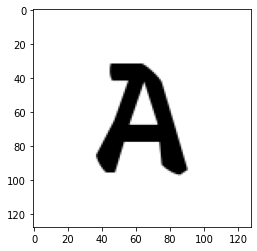

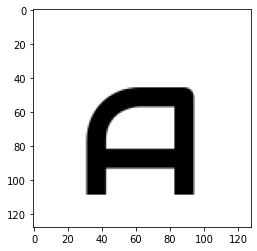

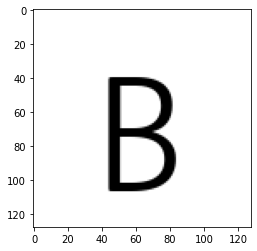

In [234]:
# t
plt.imshow(target[0, 0], cmap='gray')
plt.show()
plt.imshow(target[1, 0], cmap='gray')
plt.show()
plt.imshow(source[1], cmap='gray')
plt.show()

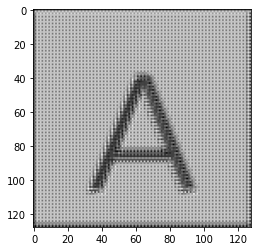

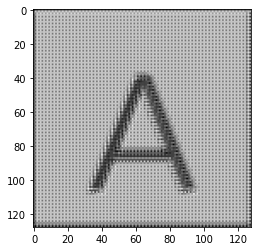

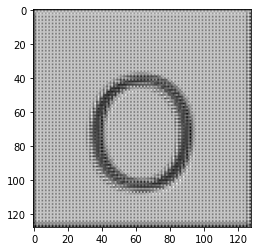

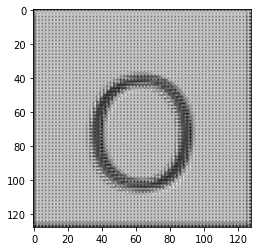

In [235]:
def generate(ch, style):
    x = torch.FloatTensor(source[ch]).reshape((1, 1, 128, 128))
    c = torch.FloatTensor(c_vec[style]).reshape((1, 128, 1, 1))
    # print(c.shape)
    z, e_net = encoder(x)
    d_in = torch.cat((z, c), dim=1)
    d_out = decoder(d_in, e_net).detach().numpy()
    # print(d_out.shape)
    # print(d_out)
    
    plt.imshow(d_out[0, 0], cmap='gray')
    plt.show()

generate(0, 0)
generate(0, 1)
generate(14, 0)
generate(14, 1)

torch.Size([1, 1, 128, 128])
tensor([[[[-0.1141,  1.3626, -0.0769,  ...,  0.3312, -1.1420,  1.4134],
          [ 1.3054,  1.4372,  4.0129,  ...,  0.5175,  1.9395,  1.8395],
          [ 0.5937,  0.5522,  1.4129,  ...,  1.1434,  2.1761,  1.6903],
          ...,
          [-0.5670,  2.3958,  6.0150,  ...,  3.8675,  0.8924,  3.1373],
          [-1.1173,  2.2598,  0.8345,  ...,  2.4139,  3.4077, -0.0268],
          [ 0.7524,  1.5841, -0.4417,  ..., -0.9988,  0.1167,  0.0973]]]],
       grad_fn=<SlowConvTranspose2DBackward>)
torch.Size([1, 512, 8, 8])
torch.Size([1, 1])
torch.Size([1, 2])


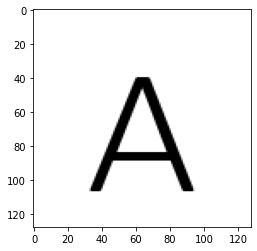

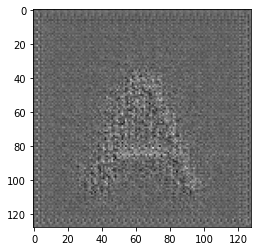

In [63]:
# Test
gx = torch.FloatTensor([source[0]]).reshape((-1,1,128,128)) / 255
style_vector = torch.FloatTensor(np.random.normal(size=(1, 128, 1, 1)))

generator = Generator(En, De)
gy = generator(gx, style_vector)

dx = gy
print(dx.shape)
print(dx)
descriminator = Discriminator(category_num=2)
dy = descriminator(dx)
print(dy[1].shape)
print(dy[2].shape)

plt.imshow(source[0], cmap='gray')
plt.show()
plt.imshow(gy.detach().numpy()[0,0], cmap='gray')
plt.show()

In [ ]:
# 실험 1
# vector = np.random.normal(size=(1, 128, 1, 1))
vector1 = torch.FloatTensor(np.random.normal(size=(1, 128)))
vector2 = torch.FloatTensor(np.random.normal(size=(1, 128)))
vector3 = torch.FloatTensor(np.random.normal(size=(1, 128)))

In [ ]:
print(torch.cdist(vector1, vector2))
print(torch.cdist(vector1, vector3))

tensor([[16.8366]])
tensor([[17.0332]])


In [ ]:
a = np.array([[-6,-2,-4]]) 
b = np.array([[1,3,2]]) 

c = torch.FloatTensor(a)
d = torch.FloatTensor(b)

print(0, c)
di = 1/3
print(1, c + (d - c) * di)
di = 2/3
print(2, c + (d - c) * di)
print(3, d)

print('distence:', torch.cdist(c, d, 1))

0 tensor([[-6., -2., -4.]])
1 tensor([[-3.6667, -0.3333, -2.0000]])
2 tensor([[-1.3333,  1.3333,  0.0000]])
3 tensor([[1., 3., 2.]])
distence: tensor([[18.]])


distence: tensor([[4.]])


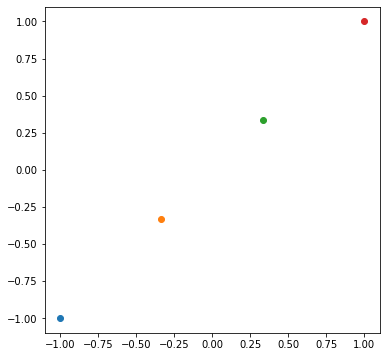

In [ ]:
a = np.array([[-1,-1]]) 
b = np.array([[1,1]]) 

c = torch.FloatTensor(a)
d = torch.FloatTensor(b)

def sub_distence(a, b, s):
    return a + (b - a) * s

print('distence:', torch.cdist(c, d, 1))
n = 4
for i in range(n):
    sp = sub_distence(c, d, i/(n-1)).numpy()[0]
    plt.scatter(sp[0], sp[1])
plt.show()

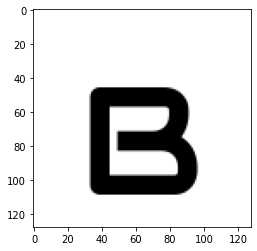

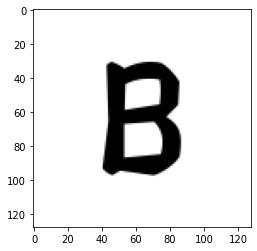

In [83]:
# t
plt.imshow(target[1,1], cmap='gray')
plt.show()
plt.imshow(source[1], cmap='gray')
plt.show()